In [1]:
push!(LOAD_PATH,"C:/JMB/DINEOF.jl/src","."); using DINEOF
using PyPlot
using LinearAlgebra
using Arpack
using Random
using Statistics

In [2]:
?DINEOF_svds!

search: DINEOF_svds! DINEOF_svd



```
U,S,V,cvEOF,cvarray,musquare=DINEOF_svds!(X,missingvalues,crossvalidation;
keeprestart=true,
ncmax=size(X)[2]-1,
istart=1,
dineofmaxiter=10,
dineoftol=0.001,
svdmeth="svd",
svdtol=0.000001,
filter="None",
filterintensity=1.0,
filterrepetitions=1
)
```

# DINEOF SVD decomposition with filling in of missing points.

# Input:

  * `X`: a two-dimensional array of size MxN with N<=M already filled in with a first guess in points with missing values
  * `missingvalues`: array of size Px2 collecting the indexes for the P missing values in location missingvalues[:,1] and missingvalues[:,2]. There is no distinction between missing values and topologically excludes points. All will be filled
  * `crossvalidation`:  array of size Qx2 collecting the indexes for the Q points to be used for cross validation
  * `keeprestart`: Boolean. If true the method keeps track of the best reconstruction up to now while doing further iterations.
  * `ncmax`: maximum number of eigenvalues calculated
  * `itstart` : defines the number of modes used during the first iteration. Then one at a time is added
  * `dineofmaxiter` : Maximum number of iterations during a SVD decomposition/filling in loop
  * `dineoftol`: Defines the tolerance below which the iterations are stopped. Relative change of xxxxx

For the other parameters, see `DINEOF_svd`

# Output:

  * `U,S,V`: the filled SVD decomposition such that in the infiltered version U*S*V' is the best approximation of X with nele singular vectors.
  * `cvEOF` : the cross validation estimator of the reconstrucion (variance of misfit at crossvalidation points)
  * `cvarray` : the cross validation estimator for different number of retained EOFs
  * `musquare` : estimation of mu^2

    WARNING: X is updated at the missing data points !!!!!!


This is the basic DINEOF iterative method to find a SVD decomposition with an incomplete matrix. If you know how to prepare the data from ND to this 2D array you can work directly with this function. Otherwise use a higher-level function DINEOFrun.

In [3]:
Random.seed!(123)

MersenneTwister(UInt32[0x0000007b], Random.DSFMT.DSFMT_state(Int32[1464307935, 1073116007, 222134151, 1073120226, -290652630, 1072956456, -580276323, 1073476387, 1332671753, 1073438661  …  138346874, 1073030449, 1049893279, 1073166535, -1999907543, 1597138926, -775229811, 32947490, 382, 0]), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], UInt128[0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000  …  0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x0000000000000

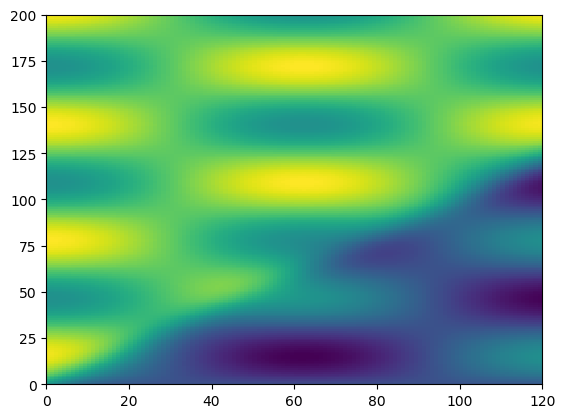

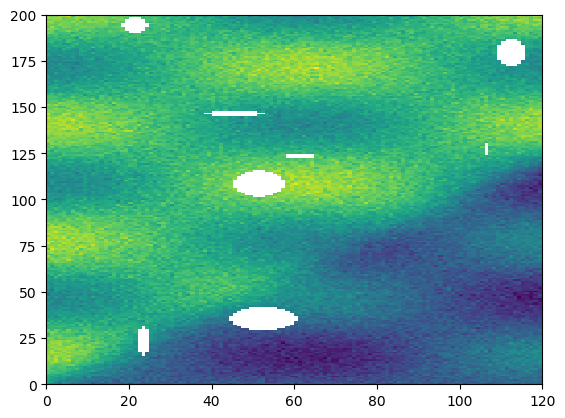

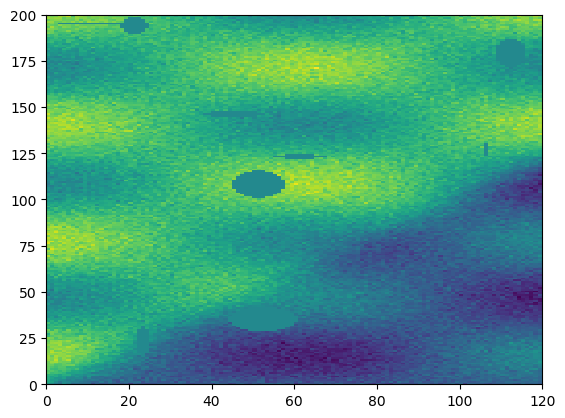

200×120 Array{Float64,2}:
 0.337762  0.0689846  -0.283882   …  -0.874699   -0.790235   -1.03684  
 0.707725  0.51854     0.0442034     -0.670443   -0.711698   -0.872719 
 0.721056  0.38878     0.35791       -0.806399   -0.440938   -0.71873  
 0.772127  0.563641    0.253975      -0.658382   -0.680095   -0.788591 
 0.77944   0.510107    0.725488      -0.73023    -0.399817   -0.76537  
 0.893111  0.874174    0.69971    …  -0.498521   -0.469253   -0.637416 
 1.37666   1.0677      1.17895       -0.16332    -0.526137   -0.666595 
 1.30573   1.36582     1.20207       -0.605451   -0.549571   -0.734273 
 1.50115   1.10811     1.0468        -0.0220277   0.0712277  -0.514731 
 1.51787   1.32773     1.17238       -0.271817   -0.490481   -0.236107 
 1.58381   1.52304     1.25755    …  -0.100835   -0.398027   -0.107608 
 1.5626    1.74799     1.46863       -0.274877    0.0685817   0.0647487
 1.61822   1.92278     2.04235       -0.179527   -0.123771    0.281373 
 ⋮                                ⋱   

In [4]:
NX=200
NY=120
X=zeros(Float64,NX,NY)
      for j=1:NY
            for i=1:NX
        X[i,j]=sin(i/10)*cos(j/20)+tanh((i-j)/10)
            end
        end
pcolor(X)
figure()
# use cvmask routing to create some bubbles and missing points
X=X+0.2*randn(size(X))
cvmask=DINEOF_cvmask(X,0.02,cvmethod="Bubbles",maxbubblesize=[20,20])
X[cvmask].=NaN
# Now real cv mask
cvmask=DINEOF_cvmask(X,0.05,cvmethod="Bubbles",maxbubblesize=[20,20])
pcolor(X)
XORI=deepcopy(X)
NM=sum(isnan.(X))
missingvalues=zeros(Int,(NM,2))
    icount=0
    for j=1:size(X)[2]
        for i=1:size(X)[1]
            if isnan(X[i,j])
                icount=icount+1
                missingvalues[icount,1]=i
                missingvalues[icount,2]=j
                # Put a random value with average variance of present data so that we can keep an eye on how total variane
                # behaves.
                X[i,j]=0
            end
        end
    end
cvpoints=zeros(Int,(sum(cvmask),2))
    icount=0
    for j=1:size(X)[2]
        for i=1:size(X)[1]
        if  cvmask[i,j]
                icount=icount+1
                cvpoints[icount,1]=i
                cvpoints[icount,2]=j
                
            end
        end
    end
figure()
pcolor(X)
XORIF=deepcopy(X)

Defaults only

In [5]:
U,S,V,cv,cva,mus=DINEOF_svds!(X,missingvalues,cvpoints,ncmax=5)

svds!: variance and mean of the entry matrix: 1.0068708497664847 , 0.38250591557906166 ; intial variance at points to fill in: 0.14631077545297544 
Convergence for 1 eofs, relative change 0.0007403332485581625 after 6 iterations
Eof loop 1 with mean squared misfit: 0.38068069954999717 
Convergence for 2 eofs, relative change 0.000528766942830624 after 6 iterations
Eof loop 2 with mean squared misfit: 0.5224455646500965 


┌ Warning: You should subtract a mean value from your data
└ @ DINEOF C:\JMB\DINEOF.jl\src\DINEOF_svds!.jl:96


Eof loop 3 with mean squared misfit: 0.21630349976791002 
Convergence for 4 eofs, relative change 0.0007831562349782743 after 10 iterations
Eof loop 4 with mean squared misfit: 0.13990052249927246 
Convergence for 5 eofs, relative change 0.0009210233935805789 after 7 iterations
Eof loop 5 with mean squared misfit: 0.12795901224920883 
Cross validation value (mean squared misfit): 0.12795901224920883 for 5 EOFs
Estimation for musquare based on DeRozier type of analysis: 0.043459975263921154
Estimation of mean error variance of reconstuctions: -0.08449903698528768 


┌ Warning: Initial Variance has been increased for filtered matrix  by factor 1.132398038218408
└ @ DINEOF C:\JMB\DINEOF.jl\src\DINEOF_svds!.jl:285


([0.0836561848690125 -0.013753201164987752 … 0.028107341991501528 -0.12780139258431372; 0.08244366366977335 0.0006581695834841916 … 0.03401109284411743 -0.0674454508828638; … ; -0.05679736483446131 0.08758399386638888 … 0.0042754383022874385 0.0939132368797252; -0.054503942576494206 0.08614139798595828 … -0.004407337245573786 0.04206299954424631], [125.84449142931311, 78.24082749514183, 69.72942626337736, 20.927615668577726, 10.279333905383384], [-0.025927714419134263 0.20914874842447742 … 0.13407109569208317 -0.17942445564170117; -0.02536893865496325 0.20504211703526357 … 0.1559982118839881 -0.17113669373075285; … ; -0.025812469222161308 0.00602099329664315 … -0.15105483633397135 -0.04670857004887749; -0.02624438485201462 0.015391502193595384 … -0.16619929523975396 0.01004431528896068], 0.12795901224920883, [0.38068069954999717, 0.5224455646500965, 0.21630349976791002, 0.13990052249927246, 0.12795901224920883], 0.043459975263921154)

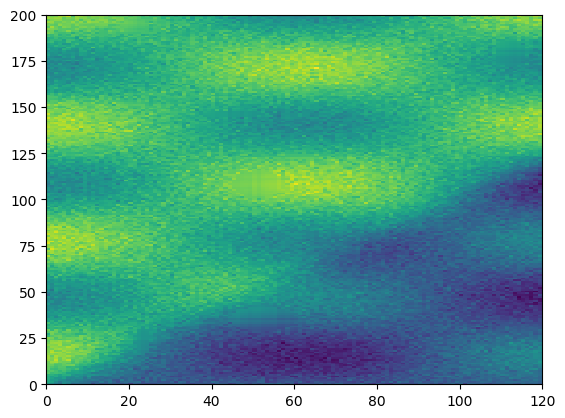

PyObject <matplotlib.collections.PolyCollection object at 0x000000003702A6A0>

In [6]:
pcolor(X)

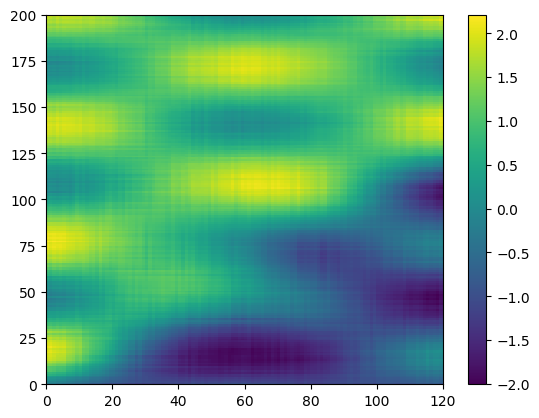

(PyObject <matplotlib.collections.PolyCollection object at 0x0000000034D96390>, PyObject <matplotlib.colorbar.Colorbar object at 0x0000000036C7B160>)

In [7]:

pcolor(U*diagm(S)*V'),colorbar()

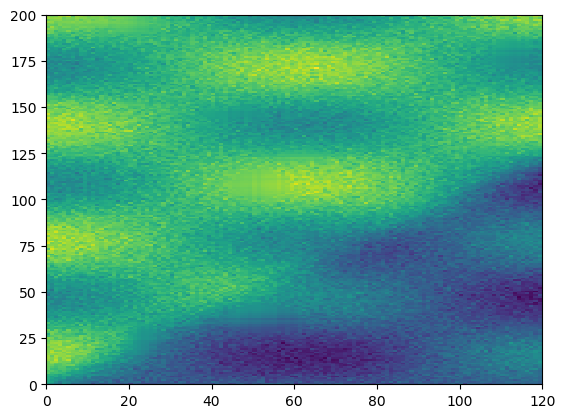

PyObject <matplotlib.collections.PolyCollection object at 0x0000000036E2A7F0>

In [8]:
X=deepcopy(XORI)
DINEOF_fuse!(X,U*diagm(S)*V',10)
pcolor(X)

In [9]:
X=deepcopy(XORIF)

200×120 Array{Float64,2}:
 0.337762  0.0689846  -0.283882   …  -0.874699   -0.790235   -1.03684  
 0.707725  0.51854     0.0442034     -0.670443   -0.711698   -0.872719 
 0.721056  0.38878     0.35791       -0.806399   -0.440938   -0.71873  
 0.772127  0.563641    0.253975      -0.658382   -0.680095   -0.788591 
 0.77944   0.510107    0.725488      -0.73023    -0.399817   -0.76537  
 0.893111  0.874174    0.69971    …  -0.498521   -0.469253   -0.637416 
 1.37666   1.0677      1.17895       -0.16332    -0.526137   -0.666595 
 1.30573   1.36582     1.20207       -0.605451   -0.549571   -0.734273 
 1.50115   1.10811     1.0468        -0.0220277   0.0712277  -0.514731 
 1.51787   1.32773     1.17238       -0.271817   -0.490481   -0.236107 
 1.58381   1.52304     1.25755    …  -0.100835   -0.398027   -0.107608 
 1.5626    1.74799     1.46863       -0.274877    0.0685817   0.0647487
 1.61822   1.92278     2.04235       -0.179527   -0.123771    0.281373 
 ⋮                                ⋱   

In [10]:
X=deepcopy(XORIF)
@time U,S,V,cv,cva,mus=DINEOF_svds!(X,missingvalues,cvpoints;ncmax=5,filter="pmf",filterrepetitions=5)

svds!: variance and mean of the entry matrix: 1.0068708497664847 , 0.38250591557906166 ; intial variance at points to fill in: 0.14631077545297544 


┌ Warning: You should subtract a mean value from your data
└ @ DINEOF C:\JMB\DINEOF.jl\src\DINEOF_svds!.jl:96


Convergence for 1 eofs, relative change 0.0006946998827244798 after 6 iterations
Eof loop 1 with mean squared misfit: 0.37898316775202284 
Convergence for 2 eofs, relative change 0.0005729478001751667 after 5 iterations
Eof loop 2 with mean squared misfit: 0.5210838850343733 
Eof loop 3 with mean squared misfit: 0.21360778367164077 
Convergence for 4 eofs, relative change 0.0009929298352720937 after 9 iterations
Eof loop 4 with mean squared misfit: 0.1367053816606474 
Convergence for 5 eofs, relative change 0.0007873450801049782 after 7 iterations
Eof loop 5 with mean squared misfit: 0.12347532063426589 
Cross validation value (mean squared misfit): 0.12347532063426589 for 5 EOFs
Estimation for musquare based on DeRozier type of analysis: 0.04579761830563807
Estimation of mean error variance of reconstuctions: -0.07767770232862782 


┌ Warning: Initial Variance has been increased for filtered matrix  by factor 1.127965872825123
└ @ DINEOF C:\JMB\DINEOF.jl\src\DINEOF_svds!.jl:285


  2.072956 seconds (1.32 M allocations: 303.186 MiB, 4.00% gc time)


([0.08380626239098032 -0.013169338182296778 … 0.02611748564721296 -0.12320497209483189; 0.08251080001798689 0.0010749545419017625 … 0.033101036326769855 -0.07184850876802575; … ; -0.05718147974884051 0.08642901213173265 … 0.00259377161608214 0.0989973918324293; -0.054888426199009716 0.08471331794029746 … -0.0030098616870640024 0.042630436867616694], [125.7108917912642, 78.06896794872561, 69.53786577555546, 20.66033256473825, 9.840059718202376], [-0.02616735485824098 0.20653735223472028 … 0.14109303958892902 -0.17379608666332091; -0.02637134349552835 0.2058854107379872 … 0.1385556687585413 -0.16989558219174264; … ; -0.027916403139556137 0.007054819832412976 … -0.1520198425969589 -0.04722920057090573; -0.027078276620523603 0.008028079794968293 … -0.15692930362603974 -0.04041309812084401], 0.12347532063426589, [0.37898316775202284, 0.5210838850343733, 0.21360778367164077, 0.1367053816606474, 0.12347532063426589], 0.04579761830563807)

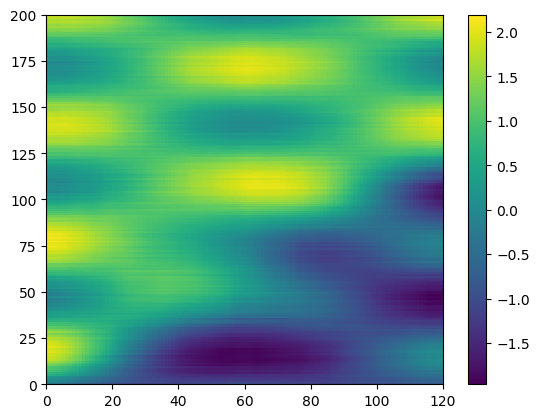

(PyObject <matplotlib.collections.PolyCollection object at 0x000000003D982CC0>, PyObject <matplotlib.colorbar.Colorbar object at 0x000000003F66F9B0>)

In [11]:
pcolor(U*diagm(S)*V'),colorbar()

In [12]:
X=deepcopy(XORIF)
@time U,S,V,cv,cva,mus=DINEOF_svds!(X,missingvalues,cvpoints;ncmax=5,filter="pmf",svdtol=0.0001,filterrepetitions=5)

svds!: variance and mean of the entry matrix: 1.0068708497664847 , 0.38250591557906166 ; intial variance at points to fill in: 0.14631077545297544 
Convergence for 1 eofs, relative change 0.0006946998827246061 after 6 iterations
Eof loop 1 with mean squared misfit: 0.37898316775202284 


┌ Warning: You should subtract a mean value from your data
└ @ DINEOF C:\JMB\DINEOF.jl\src\DINEOF_svds!.jl:96


Convergence for 2 eofs, relative change 0.0005729478001754423 after 5 iterations
Eof loop 2 with mean squared misfit: 0.5210838850343728 
Eof loop 3 with mean squared misfit: 0.21360778367164077 
Convergence for 4 eofs, relative change 0.000992929835272165 after 9 iterations
Eof loop 4 with mean squared misfit: 0.13670538166064788 
Convergence for 5 eofs, relative change 0.0007873450801048511 after 7 iterations
Eof loop 5 with mean squared misfit: 0.12347532063426649 
Cross validation value (mean squared misfit): 0.12347532063426649 for 5 EOFs
Estimation for musquare based on DeRozier type of analysis: 0.045797618305637826
Estimation of mean error variance of reconstuctions: -0.07767770232862867 
  2.085528 seconds (744.01 k allocations: 273.601 MiB, 3.18% gc time)


┌ Warning: Initial Variance has been increased for filtered matrix  by factor 1.1279658728251232
└ @ DINEOF C:\JMB\DINEOF.jl\src\DINEOF_svds!.jl:285


([-0.08380626239098055 -0.013169338182296764 … -0.026117485647212592 0.12320497209483186; -0.0825108000179869 0.0010749545419015405 … -0.033101036326770125 0.07184850876802573; … ; 0.05718147974884052 0.08642901213173278 … -0.002593771616082042 -0.09899739183242923; 0.05488842619900973 0.08471331794029756 … 0.0030098616870639187 -0.04263043686761679], [125.71089179126422, 78.06896794872559, 69.5378657755555, 20.660332564738223, 9.840059718202376], [0.02616735485824092 0.20653735223472044 … -0.1410930395889289 0.17379608666332105; 0.02637134349552846 0.20588541073798727 … -0.13855566875854208 0.16989558219174172; … ; 0.02791640313955622 0.007054819832413184 … 0.1520198425969589 0.047229200570905974; 0.027078276620523728 0.008028079794968588 … 0.15692930362604002 0.04041309812084479], 0.12347532063426649, [0.37898316775202284, 0.5210838850343728, 0.21360778367164077, 0.13670538166064788, 0.12347532063426649], 0.045797618305637826)

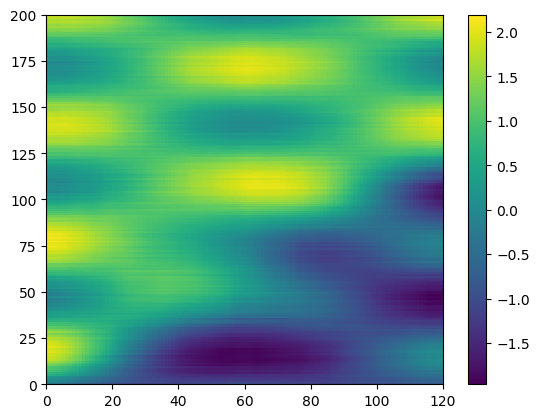

(PyObject <matplotlib.collections.PolyCollection object at 0x000000003F822F98>, PyObject <matplotlib.colorbar.Colorbar object at 0x000000003FD01D68>)

In [13]:
pcolor(U*diagm(S)*V'),colorbar()

In [14]:
cva

5-element Array{Float64,1}:
 0.37898316775202284
 0.5210838850343728 
 0.21360778367164077
 0.13670538166064788
 0.12347532063426649

In [15]:
X=deepcopy(XORIF)
@time U,S,V,cv,cva,mus=DINEOF_svds!(X,missingvalues,cvpoints;ncmax=5)

svds!: variance and mean of the entry matrix: 1.0068708497664847 , 0.38250591557906166 ; intial variance at points to fill in: 0.14631077545297544 
Convergence for 1 eofs, relative change 0.0007403332485577607 after 6 iterations
Eof loop 1 with mean squared misfit: 0.38068069954999695 

┌ Warning: You should subtract a mean value from your data
└ @ DINEOF C:\JMB\DINEOF.jl\src\DINEOF_svds!.jl:96



Convergence for 2 eofs, relative change 0.0005287669428309925 after 6 iterations
Eof loop 2 with mean squared misfit: 0.5224455646500956 
Eof loop 3 with mean squared misfit: 0.21630349976790983 
Convergence for 4 eofs, relative change 0.0007831562349786197 after 10 iterations
Eof loop 4 with mean squared misfit: 0.13990052249927232 
Convergence for 5 eofs, relative change 0.0009210233935801758 after 7 iterations
Eof loop 5 with mean squared misfit: 0.12795901224920894 
Cross validation value (mean squared misfit): 0.12795901224920894 for 5 EOFs
Estimation for musquare based on DeRozier type of analysis: 0.04345997526392129
Estimation of mean error variance of reconstuctions: -0.08449903698528766 
  0.392473 seconds (743.67 k allocations: 37.898 MiB, 1.99% gc time)


┌ Warning: Initial Variance has been increased for filtered matrix  by factor 1.1323980382184082
└ @ DINEOF C:\JMB\DINEOF.jl\src\DINEOF_svds!.jl:285


([-0.0836561848690125 0.013753201164987655 … 0.028107341991501555 0.12780139258431586; -0.08244366366977335 -0.0006581695834841916 … 0.0340110928441176 0.06744545088286244; … ; 0.05679736483446128 -0.0875839938663889 … 0.0042754383022873856 -0.09391323687972887; 0.0545039425764942 -0.0861413979859582 … -0.004407337245573851 -0.04206299954424703], [125.84449142931314, 78.2408274951418, 69.72942626337736, 20.92761566857772, 10.279333905383382], [0.02592771441913416 -0.2091487484244774 … 0.13407109569208342 0.17942445564171464; 0.025368938654963143 -0.20504211703526345 … 0.15599821188398838 0.17113669373076568; … ; 0.025812469222161412 -0.0060209932966430665 … -0.15105483633397115 0.04670857004888984; 0.026244384852014732 -0.015391502193595377 … -0.16619929523975402 -0.010044315288956614], 0.12795901224920894, [0.38068069954999695, 0.5224455646500956, 0.21630349976790983, 0.13990052249927232, 0.12795901224920894], 0.04345997526392129)

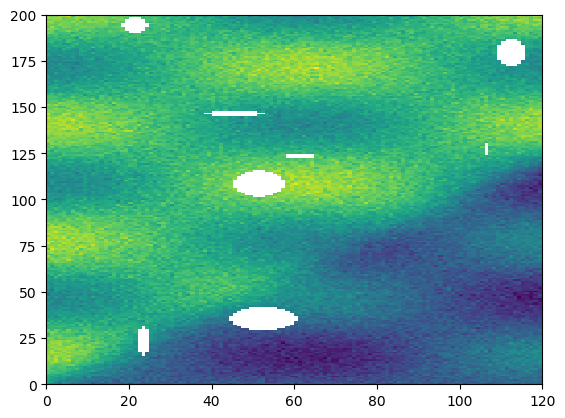

PyObject <matplotlib.collections.PolyCollection object at 0x000000003FD3B2B0>

In [16]:
pcolor(XORI)

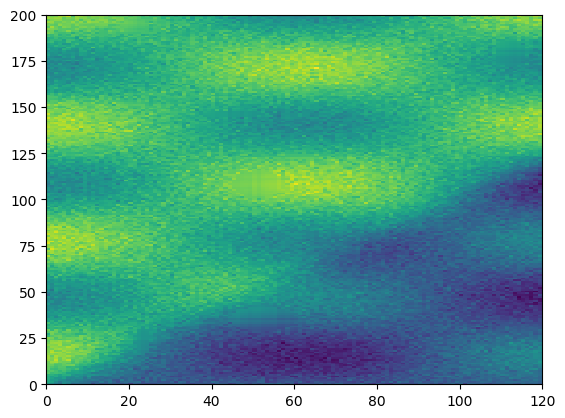

PyObject <matplotlib.collections.PolyCollection object at 0x0000000040CAE710>

In [17]:
pcolor(X)

Example on how to fuse filtered and unfiltered data

In [18]:
X=deepcopy(XORI)
DINEOF_fuse!(X,U*diagm(S)*V',10)

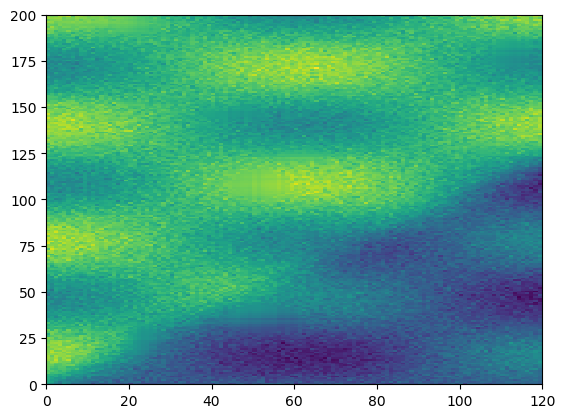

PyObject <matplotlib.collections.PolyCollection object at 0x0000000042943BA8>

In [19]:
pcolor(X)